In [24]:
import pandas as pd
import numpy as np

df = pd.read_csv('all_data.csv')
df = df.dropna(subset=['pm25'])
df

,Unnamed: 0.1,Unnamed: 0,date,stacja,pm25,temperature_2m_min,wind_speed_10m_max,wind_direction_10m_dominant,cloud_cover_mean,surface_pressure_mean,...,boundary_layer_height,lat,lon,nearest_road_dist_m,total_road_length_km,building_count,elevation,population,built_up_surface,built_up_volume
0,0,0,2016-01-01 00:00:00+00:00,DsLegAlRzecz,59.30,-1.932500,11.753877,289.29013,100.000000,1010.14970,...,191.66667,51.204503,16.180513,98.613062,942.949585,15745.0,124.0,101762.211892,6385774.0,45643207.0
1,1,1,2016-01-02 00:00:00+00:00,DsLegAlRzecz,54.70,-9.532500,22.896110,102.65439,59.958332,1009.82965,...,433.12500,51.204503,16.180513,98.613062,942.949585,15745.0,124.0,101762.211892,6385774.0,45643207.0
2,2,2,2016-01-03 00:00:00+00:00,DsLegAlRzecz,69.00,-12.282500,18.709612,107.50388,49.416668,1003.64520,...,398.33334,51.204503,16.180513,98.613062,942.949585,15745.0,124.0,101762.211892,6385774.0,45643207.0
3,3,3,2016-01-04 00:00:00+00:00,DsLegAlRzecz,80.10,-10.632501,20.696087,118.76107,92.458336,985.55080,...,477.91666,51.204503,16.180513,98.613062,942.949585,15745.0,124.0,101762.211892,6385774.0,45643207.0
4,4,4,2016-01-05 00:00:00+00:00,DsLegAlRzecz,100.50,-7.082500,13.324863,86.64323,95.750000,985.00410,...,268.75000,51.204503,16.180513,98.613062,942.949585,15745.0,124.0,101762.211892,6385774.0,45643207.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66912,66912,66912,2018-12-28 00:00:00+00:00,ZpSzczec1Maj,4.90,4.139000,24.535526,298.53427,100.000000,1003.10750,...,728.54170,53.712114,16.692517,23.818303,544.823893,8120.0,138.0,43274.445438,2695519.0,19724737.0
66913,66913,66913,2018-12-29 00:00:00+00:00,ZpSzczec1Maj,8.16,3.889000,17.555307,256.10280,99.958336,1004.09380,...,552.08330,53.712114,16.692517,23.818303,544.823893,8120.0,138.0,43274.445438,2695519.0,19724737.0
66914,66914,66914,2018-12-30 00:00:00+00:00,ZpSzczec1Maj,4.35,1.689000,27.002400,298.98737,95.958336,1000.37670,...,665.83330,53.712114,16.692517,23.818303,544.823893,8120.0,138.0,43274.445438,2695519.0,19724737.0
66915,66915,66915,2018-12-31 00:00:00+00:00,ZpSzczec1Maj,7.44,1.839000,20.883102,271.19727,98.791664,1009.56620,...,395.62500,53.712114,16.692517,23.818303,544.823893,8120.0,138.0,43274.445438,2695519.0,19724737.0


In [25]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

# Załóżmy, że masz df z kolumną 'stacja', 'date' i cechami oraz target pm25
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df = df.sort_values(['stacja', 'date'])

# Przykład wybranych cech
features = ['temperature_2m_min', 'wind_speed_10m_max', 'wind_direction_10m_dominant',
            'cloud_cover_mean', 'surface_pressure_mean', 'dew_point_2m_mean',
            'boundary_layer_height',
            'nearest_road_dist_m', 'total_road_length_km', 'building_count',
            'elevation', 'population', 'built_up_surface', 'built_up_volume',
            'year', 'month', 'day', 'weekday']  # + inne
target = 'pm25'

# Skalowanie cech (bardzo ważne dla LSTM)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Funkcja do tworzenia sekwencji i targetów
def create_sequences(data, feature_cols, target_col, lookback=14, forecast_horizon=1):
    X, y = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        seq_x = data[feature_cols].iloc[i:i+lookback].values
        seq_y = data[target_col].iloc[i+lookback+forecast_horizon-1]  # predykcja 5 dni do przodu
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Przygotuj dane per stacja
X_list, y_list = [], []
for stacja, group in df.groupby('stacja'):
    group = group.sort_values('date')
    # Skaluje cechy i target per stacja (możesz też globalnie)
    scaled_features = scaler_X.fit_transform(group[features])
    scaled_target = scaler_y.fit_transform(group[[target]])
    
    scaled_df = pd.DataFrame(scaled_features, columns=features)
    scaled_df[target] = scaled_target
    
    X_seq, y_seq = create_sequences(scaled_df, features, target, lookback=30, forecast_horizon=5)
    X_list.append(X_seq)
    y_list.append(y_seq)

X_all = np.vstack(X_list)
y_all = np.hstack(y_list)

# Podział na train/test (np. 80/20 losowo)
split = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

# Budowa modelu LSTM
'''
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
'''
model = Sequential()
model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# Trening z informacją o postępach
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1)

# Ewaluacja
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')

# Predykcje i odwrócenie skalowania jeśli potrzeba
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1,1))


c:\Users\szymo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 89s 30ms/step - loss: 0.4538 - val_loss: 0.3837
Epoch 2/30
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 116s 21ms/step - loss: 0.3514 - val_loss: 0.3365
Epoch 3/30
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - loss: 0.3031 - val_loss: 0.3457
Epoch 4/30
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 57s 21ms/step - loss: 0.2753 - val_loss: 0.3322
Epoch 5/30
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 54s 20ms/step - loss: 0.2514 - val_loss: 0.3390
Epoch 6/30
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 54s 19ms/step - loss: 0.2309 - val_loss: 0.3033
Epoch 7/30
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 54s 19ms/step - loss: 0.2150 - val_loss: 0.3100
Epoch 8/30
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 54s 19ms/step - loss: 0.2021 - val_loss: 0.3049
Epoch 9/30
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 54s 19ms/step - loss: 0.1863 - val_loss: 0.3531
Epoch 10/30
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 57s 20ms/step - loss: 0.1754 - val_loss: 0.3501
Epoch 11/30
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 58s 21ms/step - loss: 0.1673 - val_loss: 0.3059
Epoch 1

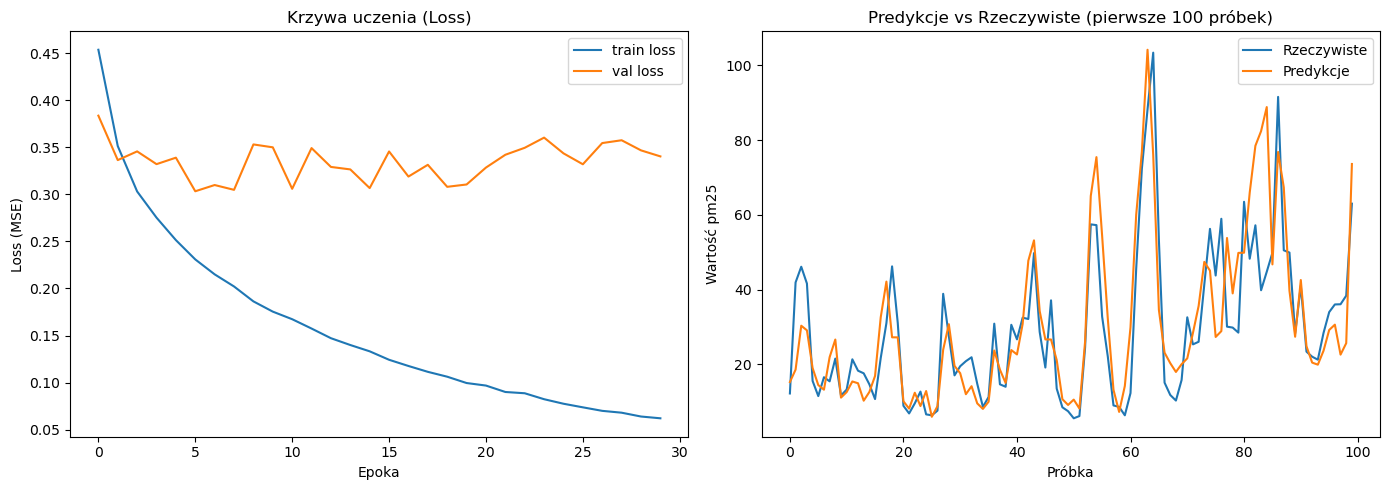

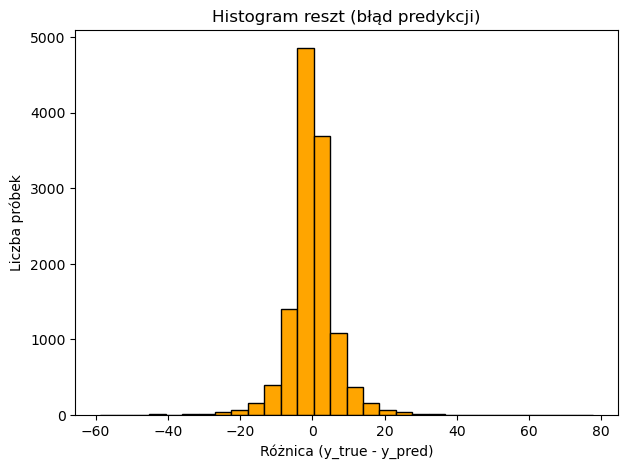

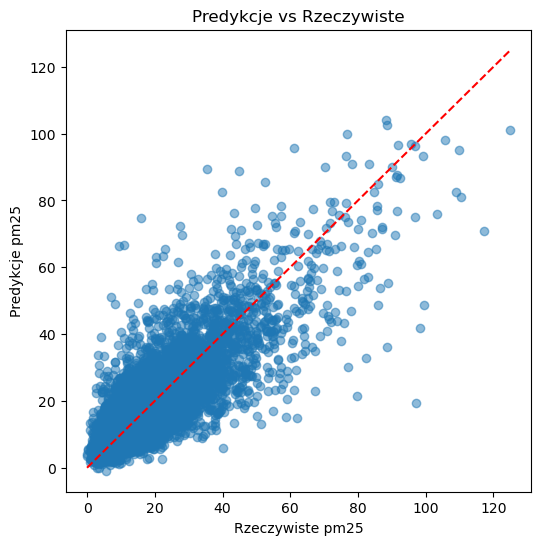

MAE: 4.258
RMSE: 6.622
R^2: 0.689


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_lstm_diagnostics(history, y_test_rescaled, y_pred_rescaled):
    """
    Rysuje wykresy diagnostyczne po trenowaniu LSTM.

    Args:
        history: Obiekt zwrócony przez model.fit() (historia treningu).
        y_test_rescaled: Prawdziwe wartości (odwrócone skalowanie), np. pm25.
        y_pred_rescaled: Predykcje modelu (odwrócone skalowanie).
    """

    # 1. Krzywa uczenia
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history.get('val_loss', []), label='val loss')
    plt.title('Krzywa uczenia (Loss)')
    plt.xlabel('Epoka')
    plt.ylabel('Loss (MSE)')
    plt.legend()

    # 2. Porównanie predykcji i prawdziwych wartości (np. pierwsze 100 próbek)
    plt.subplot(1,2,2)
    plt.plot(y_test_rescaled[:100], label='Rzeczywiste')
    plt.plot(y_pred_rescaled[:100], label='Predykcje')
    plt.title('Predykcje vs Rzeczywiste (pierwsze 100 próbek)')
    plt.xlabel('Próbka')
    plt.ylabel('Wartość pm25')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Histogram reszt
    residuals = y_test_rescaled.flatten() - y_pred_rescaled.flatten()
    plt.figure(figsize=(7,5))
    plt.hist(residuals, bins=30, color='orange', edgecolor='k')
    plt.title('Histogram reszt (błąd predykcji)')
    plt.xlabel('Różnica (y_true - y_pred)')
    plt.ylabel('Liczba próbek')
    plt.show()

    # 4. Scatter plot: predykcje vs rzeczywiste
    plt.figure(figsize=(6,6))
    plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.5)
    plt.plot([y_test_rescaled.min(), y_test_rescaled.max()],
             [y_test_rescaled.min(), y_test_rescaled.max()], 'r--')  # linia y=x
    plt.title('Predykcje vs Rzeczywiste')
    plt.xlabel('Rzeczywiste pm25')
    plt.ylabel('Predykcje pm25')
    plt.show()

    # 5. Metryki
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    rmse = mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    print(f'MAE: {mae:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'R^2: {r2:.3f}')

plot_lstm_diagnostics(history, y_test_rescaled, y_pred_rescaled)

In [27]:
model.save('moj_model_lstm_wielezmiennych2.h5')  # zapis do pliku .h5

In [ ]:

#dzielenie po czasie


import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['stacja', 'date'])

features = ['temperature_2m_min', 'wind_speed_10m_max', 'cloud_cover_mean']  # + inne
target = 'pm25'

scaler_X = StandardScaler()
scaler_y = StandardScaler()

def create_sequences(data, feature_cols, target_col, lookback=30, forecast_horizon=5):
    X, y = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        seq_x = data[feature_cols].iloc[i:i+lookback].values
        seq_y = data[target_col].iloc[i+lookback+forecast_horizon-1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

for stacja, group in df.groupby('stacja'):
    group = group.sort_values('date')
    
    # Skalowanie per stacja
    scaled_features = scaler_X.fit_transform(group[features])
    scaled_target = scaler_y.fit_transform(group[[target]])
    
    scaled_df = pd.DataFrame(scaled_features, columns=features)
    scaled_df[target] = scaled_target
    
    split_index = int(len(scaled_df) * 0.8)
    
    train_data = scaled_df.iloc[:split_index]
    test_data = scaled_df.iloc[split_index:]
    
    X_train_seq, y_train_seq = create_sequences(train_data, features, target, lookback=30, forecast_horizon=5)
    X_test_seq, y_test_seq = create_sequences(test_data, features, target, lookback=30, forecast_horizon=5)
    
    X_train_list.append(X_train_seq)
    y_train_list.append(y_train_seq)
    X_test_list.append(X_test_seq)
    y_test_list.append(y_test_seq)

X_train = np.vstack(X_train_list)
y_train = np.hstack(y_train_list)
X_test = np.vstack(X_test_list)
y_test = np.hstack(y_test_list)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

# Dalej budujesz i trenujes model LSTM jak wcześniej
# Budowa modelu LSTM
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Trening z informacją o postępach
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Ewaluacja
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')

# Predykcje i odwrócenie skalowania jeśli potrzeba
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1,1))


In [ ]:
#dzielenie po stacjach


import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['stacja', 'date'])

features = ['temperature_2m_min', 'wind_speed_10m_max', 'cloud_cover_mean']  # dodaj swoje cechy
target = 'pm25'

scaler_X = StandardScaler()
scaler_y = StandardScaler()

def create_sequences(data, feature_cols, target_col, lookback=30, forecast_horizon=5):
    X, y = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        seq_x = data[feature_cols].iloc[i:i+lookback].values
        seq_y = data[target_col].iloc[i+lookback+forecast_horizon-1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Lista unikalnych stacji
stations = df['stacja'].unique()
np.random.seed(42)
train_stations = np.random.choice(stations, size=50, replace=False)
test_stations = [s for s in stations if s not in train_stations]

X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

for stacja, group in df.groupby('stacja'):
    group = group.sort_values('date')
    
    # Skalowanie per stacja
    scaled_features = scaler_X.fit_transform(group[features])
    scaled_target = scaler_y.fit_transform(group[[target]])
    
    scaled_df = pd.DataFrame(scaled_features, columns=features)
    scaled_df[target] = scaled_target
    
    X_seq, y_seq = create_sequences(scaled_df, features, target, lookback=30, forecast_horizon=5)
    
    if stacja in train_stations:
        X_train_list.append(X_seq)
        y_train_list.append(y_seq)
    else:
        X_test_list.append(X_seq)
        y_test_list.append(y_seq)

X_train = np.vstack(X_train_list)
y_train = np.hstack(y_train_list)
X_test = np.vstack(X_test_list)
y_test = np.hstack(y_test_list)

print(f"Liczba próbek treningowych: {X_train.shape[0]}")
print(f"Liczba próbek testowych: {X_test.shape[0]}")

# Teraz możesz trenować LSTM na X_train, y_train i testować na X_test, y_test
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Trening z informacją o postępach
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Ewaluacja
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')

# Predykcje i odwrócenie skalowania jeśli potrzeba
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1,1))
